<h2>DCGAN CIFAR-100

<h3>References
<h3>__________________________________
<h5>https://www.mathworks.com/help/deeplearning/ug/monitor-gan-training-progress-and-identify-common-failure-modes.html
<h5>https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

In [1]:
from keras.datasets import cifar10
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, BatchNormalization,Conv2D, Dropout,Dropout,AveragePooling2D,Reshape,Conv2DTranspose,LeakyReLU,ReLU
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import random
from numpy.random import randint,randn
from sklearn.model_selection import train_test_split

In [2]:
(X_train,y_train), (X_test,y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


In [3]:
import numpy as np
import matplotlib.pyplot as plt
labels=len(np.unique(y_train))
print('Training data shape: ', X_train.shape, y_train.shape)

print('Testing data shape: ', X_test.shape, y_test.shape)
print('No. of Unique Labels:',labels)
print('Labels:',np.unique(y_train))
print('Data Type:' ,type(X_train[0][0]))

Training data shape:  (50000, 32, 32, 3) (50000, 1)
Testing data shape:  (10000, 32, 32, 3) (10000, 1)
No. of Unique Labels: 10
Labels: [0 1 2 3 4 5 6 7 8 9]
Data Type: <class 'numpy.ndarray'>


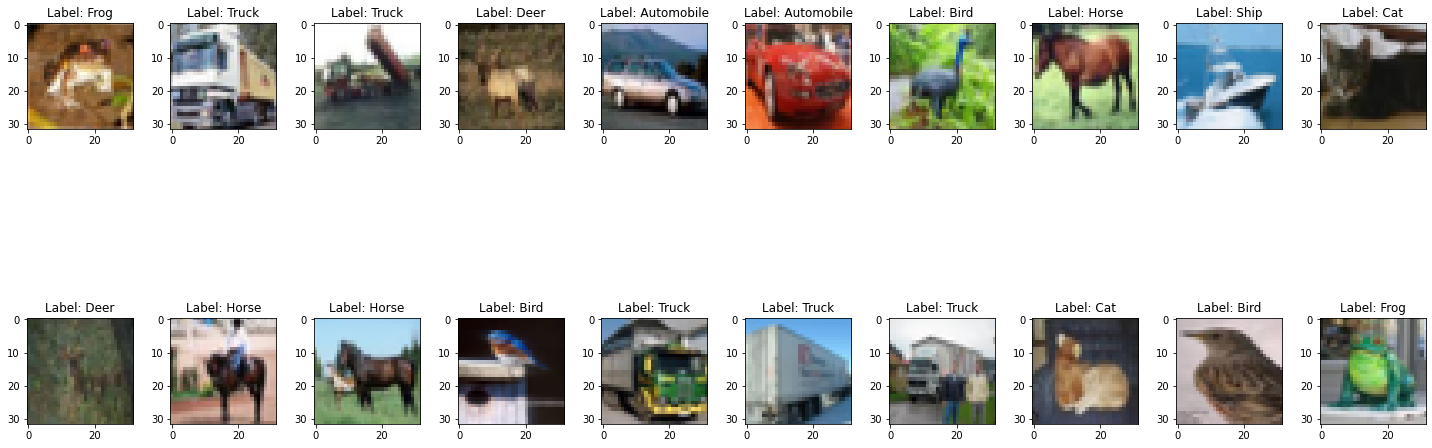

In [4]:
labels_map={
    0: 'Airplane', 1: 'Automobile', 2: 'Bird', 3: 'Cat', 4: 'Deer',
    5: 'Dog', 6: 'Frog', 7: 'Horse', 8: 'Ship', 9: 'Truck'} # https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data
row = 2
col = 10
num= row*col
# get images
images = X_train[0:num]
labels = y_train[0:num]
# plot images
fig, axes = plt.subplots(row, col, figsize=(20,10))
for i in range(num):
     ax = axes[i//col, i%col]
     ax.imshow(images[i], cmap='gray_r')
     ax.set_title('Label: {}'.format(labels_map[labels[i][0]]))
plt.tight_layout()
plt.show()

<h2>Data Preprocessing

scale from [0,255] to [-1,1], best practice

In [5]:
X_train=X_train.reshape((50000,32,32,3))
X_train_normal=X_train.astype('float32')/127.5 #using tanh in generator so it will provide values from -1 to 1
# X_test=X_test.reshape((10000,32,32,3))
# X_test_normal=X_test.astype('float32')/127.5

<h2>Defining Discriminator Model
<h4> Inputs: Image (32,32,3)
<h4>Outputs: Binary classification, 0=Fake,1=Real.
<h5>Used a basic GAN Model Architecture from https://www.researchgate.net/figure/The-architecture-of-the-first-GAN-network-a-the-generator-and-b-the-discriminator_fig4_339100419

in GANs, fully-connected layers are not used, in the discriminator and the convolutional layers are flattened and passed directly to the output layer.

In [6]:
#use the LeakyReLU with a default slope of 0.2, reported as a best practice when training GAN models.
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    model.add(Conv2D(32, (3,3),strides=(2,2),padding='same',input_shape=in_shape)) 
    model.add(LeakyReLU(alpha=0.2))
    #input-layer is padded in a way so that the output layer has a shape of the input divided by the stride.
    #downsampling, reduces dimensionality and storage size
    # we do not use pooling layers and use the large stride to achieve downsampling
    model.add(Conv2D(64, (3,3),strides=(2,2),padding='same')) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3),strides=(2,2), padding='same')) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3),strides=(2,2), padding='same')) 
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    #using a larger stride can make the generator faster to train, but it may produce lower-quality images. 
    # On the other hand, using a smaller stride can produce higher-quality images, but it may be slower to train.
    optimizer=Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model
discriminator=define_discriminator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         2

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


<h2>Defining Generator Model

<h3>Baseline Generator

Developing a generator model requires that we transform a vector from the latent space 
to a 2D array with 32 x 32 x 3, or 3,072 values.

The first is a Dense layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image. It needs enough nodes for multiple versions of our output image, such as 256.

In [7]:
def define_generator(latent_dim):
    #drawing points from latent_dim randomly
    #generator will assign meaning to the latent points and, in turn, the latent space

    #At the end, the latent vector space represents a compressed representation of CIFAR-10 images, 
    #that only the generator knows how to turn into CIFAR-10 images.
    model=Sequential()
    #Inputs: Point in latent space
    model.add(Dense((256*4*4),activation='leaky_relu',input_dim=latent_dim))#latent dim is 1d vector, 4,4 
    model.add(Reshape((4,4,256)))#Reshaped into 4,4,256 dimensions to apply convolutional operations

    #upsample from 4,4 to 32,32 gradually upsampling layer
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')) # plots image features on map 128 images due to 128 filters
    model.add(LeakyReLU(alpha=0.2))
    #output shape is forced to become the input shape multiplied by the stride
    #strides increase spatial resolution of feat map,generates higher resolution images4*2=8, used kernel size 4 to prevent checkboarding of 
    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')) #
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    # Outputs: Two-dimensional square color image (3 channels) of 32 x 32 pixels with pixel values in [-1,1]
    return model
    #three filters for the three required channels
    #not compiled because it is not directly trained like discriminator


<h5>Latent Spaces, where the generator network learns to generate synthetic data

<h5>Compact representation:easier to learn patterns and features in the data and to generate new samples that are similar to the real data.

<h5>Interpolation: smoothly interpolate between points in the latent space. This can be useful for generating new samples that are "in between" two existing samples, Smooth transition of styles and colors of data
<h5>Controlled generation: possible to control the properties of the generated samples by manipulating the latent space. Syle/Class etc

In [8]:
#size of space
latent_dim= 100

#Pass random point sample into generator to get synthetic data point
generator = define_generator(latent_dim)

generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)      

In [9]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    #array of random numbers reshaped into samples, n rows with 100 elements per row
    x_input =  randn(latent_dim * n_samples)
    # reshape into batch of inputs for network
    x_input = x_input.reshape(n_samples, latent_dim)
    # print(x_input)
    return x_input

<h4>Batch of fake and real images

In [10]:
def real_samples(df,samples):
    #random images
    img=randint(0,df.shape[0],samples)
    X_train=df[img]
    y_train=np.ones((samples,1)) #labels =1 = real images
    return X_train,y_train
    
#use generator to produce fake samples with class label, fetch fake img
#Use generate_latent_points to generate latent points hence need input latent dim and batch
def fake_samples(generator,latent_dim,samples):
    #generate the required number of points in latent space as input to the model.
    X_input=generate_latent_points(latent_dim,samples)
    #predict to generate fake samples
    X=generator.predict(X_input)
    y=np.zeros((samples,1)) #labels =0 = fake images
    return X,y

<h3>Combined GAN Model

<h3>Inputs: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.
<h3>Outputs: Binary classification, likelihood the sample is real (or fake).

Combining generator and discriminator model, discriminator not trainable and to only train the generator

We do this so that backpropagation process will update generator weights when discriminator gives generated samples a low 0.3-0.5 probability</p>
So it will update the weights accordingly to correct the error

In [11]:
def define_gan(generator,discriminator):
    discriminator.trainable=False #discriminator trained separately, hence weights are freezed
    model=Sequential()
    model.add(generator)
    model.add(discriminator)
    optimizer=Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=optimizer)
    return model

<h3>Training

50/50 real/fake image into discriminator

Noise vector input for generator output fake images for discriminator

In [17]:

def train(g_model,d_model,gan_model,df,latent_dim,epochs=100,batchsize=128):
    batch_per_epoch=int(df.shape[0]/batchsize)
    half_batch=int(batchsize/2)
    g_array=[]
    d_array=[]
    #discriminator is updated for half batch of real and fake samples as one batch
    for ep in range(epochs): #in every epoch
        for batch in range(batch_per_epoch): #in every batch
            X_real,y_real=real_samples(df,half_batch)
            d_loss_real,_ =d_model.train_on_batch(X_real,y_real) #update weights on real img

            X_fake,y_fake=fake_samples(g_model,latent_dim,half_batch)
            d_loss_fake,_=d_model.train_on_batch(X_fake,y_fake)#update weights on fake img
            #averaged
            d_loss=(d_loss_fake+d_loss_real)/2
            #training generator using gan 
            X_gan=generate_latent_points(latent_dim,batchsize) #input for generator
            y_gan= np.ones((batchsize,1))#label generated as real label =1
            g_loss=gan_model.train_on_batch(X_gan,y_gan) #training gan model
            
            print(f"Epoch {ep+1} Batch {batch+1}/{batch_per_epoch} d_loss_real= {d_loss_real:.3f}, d_loss_fake= {d_loss_fake:.3f}, g_loss {g_loss:.3f}, d_loss {d_loss:.3f}")
            if batch+1==batch_per_epoch:
                g_array.append(g_loss)
                d_array.append(d_loss)
        if ep%50==0:
            g_model.save(f'{ep}base50.h5')
        else:
            g_model.save(f'{ep}base50.h5')
    return g_array,d_array


In [18]:
gan_model=define_gan(generator,discriminator)
g_array, d_array =train(generator,discriminator,gan_model,X_train_normal,latent_dim,52)

2/2 [==============================] - 0s 7ms/step
Epoch 1 Batch 1/390 d_loss_real= 1.412, d_loss_fake= 0.231, g_loss 1.633, d_loss 0.822
2/2 [==============================] - 0s 7ms/step
Epoch 1 Batch 2/390 d_loss_real= 1.404, d_loss_fake= 0.218, g_loss 1.640, d_loss 0.811
2/2 [==============================] - 0s 6ms/step
Epoch 1 Batch 3/390 d_loss_real= 1.316, d_loss_fake= 0.223, g_loss 1.595, d_loss 0.770
2/2 [==============================] - 0s 6ms/step
Epoch 1 Batch 4/390 d_loss_real= 1.128, d_loss_fake= 0.239, g_loss 1.515, d_loss 0.683
2/2 [==============================] - 0s 6ms/step
Epoch 1 Batch 5/390 d_loss_real= 0.797, d_loss_fake= 0.266, g_loss 1.418, d_loss 0.532
2/2 [==============================] - 0s 6ms/step
Epoch 1 Batch 6/390 d_loss_real= 0.550, d_loss_fake= 0.304, g_loss 1.302, d_loss 0.427
2/2 [==============================] - 0s 5ms/step
Epoch 1 Batch 7/390 d_loss_real= 0.398, d_loss_fake= 0.377, g_loss 1.123, d_loss 0.388
2/2 [=============================

Epoch 1 Batch 390/390 d_loss_real= 0.060, d_loss_fake= 0.060, g_loss 2.862, d_loss 0.060
2/2 [==============================] - 0s 5ms/step
Epoch 2 Batch 1/390 d_loss_real= 0.077, d_loss_fake= 0.060, g_loss 2.859, d_loss 0.068
2/2 [==============================] - 0s 6ms/step
Epoch 2 Batch 2/390 d_loss_real= 0.224, d_loss_fake= 0.069, g_loss 2.734, d_loss 0.146
2/2 [==============================] - 0s 6ms/step
Epoch 2 Batch 3/390 d_loss_real= 0.098, d_loss_fake= 0.074, g_loss 2.764, d_loss 0.086
2/2 [==============================] - 0s 9ms/step
Epoch 2 Batch 4/390 d_loss_real= 0.080, d_loss_fake= 0.063, g_loss 2.886, d_loss 0.071
2/2 [==============================] - 0s 6ms/step
Epoch 2 Batch 5/390 d_loss_real= 0.102, d_loss_fake= 0.056, g_loss 2.940, d_loss 0.079
2/2 [==============================] - 0s 6ms/step
Epoch 2 Batch 6/390 d_loss_real= 0.170, d_loss_fake= 0.056, g_loss 2.910, d_loss 0.113
2/2 [==============================] - 0s 6ms/step
Epoch 2 Batch 7/390 d_loss_real=

Epoch 2 Batch 390/390 d_loss_real= 0.002, d_loss_fake= 0.001, g_loss 6.825, d_loss 0.002
2/2 [==============================] - 0s 6ms/step
Epoch 3 Batch 1/390 d_loss_real= 0.002, d_loss_fake= 0.001, g_loss 6.827, d_loss 0.002
2/2 [==============================] - 0s 7ms/step
Epoch 3 Batch 2/390 d_loss_real= 0.003, d_loss_fake= 0.001, g_loss 6.831, d_loss 0.002
2/2 [==============================] - 0s 7ms/step
Epoch 3 Batch 3/390 d_loss_real= 0.004, d_loss_fake= 0.001, g_loss 6.837, d_loss 0.003
2/2 [==============================] - 0s 5ms/step
Epoch 3 Batch 4/390 d_loss_real= 0.005, d_loss_fake= 0.001, g_loss 6.842, d_loss 0.003
2/2 [==============================] - 0s 6ms/step
Epoch 3 Batch 5/390 d_loss_real= 0.002, d_loss_fake= 0.001, g_loss 6.848, d_loss 0.001
2/2 [==============================] - 0s 5ms/step
Epoch 3 Batch 6/390 d_loss_real= 0.003, d_loss_fake= 0.001, g_loss 6.852, d_loss 0.002
2/2 [==============================] - 0s 8ms/step
Epoch 3 Batch 7/390 d_loss_real=

Epoch 3 Batch 390/390 d_loss_real= 0.000, d_loss_fake= 0.000, g_loss 8.288, d_loss 0.000
2/2 [==============================] - 0s 6ms/step
Epoch 4 Batch 1/390 d_loss_real= 0.000, d_loss_fake= 0.000, g_loss 8.293, d_loss 0.000
2/2 [==============================] - 0s 9ms/step
Epoch 4 Batch 2/390 d_loss_real= 0.000, d_loss_fake= 0.000, g_loss 8.301, d_loss 0.000
2/2 [==============================] - 0s 8ms/step
Epoch 4 Batch 3/390 d_loss_real= 0.000, d_loss_fake= 0.000, g_loss 8.299, d_loss 0.000
2/2 [==============================] - 0s 6ms/step
Epoch 4 Batch 4/390 d_loss_real= 0.004, d_loss_fake= 0.000, g_loss 8.307, d_loss 0.002
2/2 [==============================] - 0s 7ms/step
Epoch 4 Batch 5/390 d_loss_real= 0.000, d_loss_fake= 0.000, g_loss 8.316, d_loss 0.000
2/2 [==============================] - 0s 6ms/step
Epoch 4 Batch 6/390 d_loss_real= 0.000, d_loss_fake= 0.000, g_loss 8.313, d_loss 0.000
2/2 [==============================] - 0s 7ms/step
Epoch 4 Batch 7/390 d_loss_real=

Epoch 4 Batch 390/390 d_loss_real= 0.024, d_loss_fake= 0.015, g_loss 4.478, d_loss 0.020
2/2 [==============================] - 0s 5ms/step
Epoch 5 Batch 1/390 d_loss_real= 0.025, d_loss_fake= 0.047, g_loss 3.445, d_loss 0.036
2/2 [==============================] - 0s 4ms/step
Epoch 5 Batch 2/390 d_loss_real= 0.019, d_loss_fake= 4.711, g_loss 0.015, d_loss 2.365
2/2 [==============================] - 0s 5ms/step
Epoch 5 Batch 3/390 d_loss_real= 0.035, d_loss_fake= 5.020, g_loss 0.014, d_loss 2.527
2/2 [==============================] - 0s 8ms/step
Epoch 5 Batch 4/390 d_loss_real= 0.105, d_loss_fake= 3.808, g_loss 0.053, d_loss 1.956
2/2 [==============================] - 0s 5ms/step
Epoch 5 Batch 5/390 d_loss_real= 0.270, d_loss_fake= 2.322, g_loss 0.238, d_loss 1.296
2/2 [==============================] - 0s 7ms/step
Epoch 5 Batch 6/390 d_loss_real= 0.611, d_loss_fake= 1.057, g_loss 0.842, d_loss 0.834
2/2 [==============================] - 0s 8ms/step
Epoch 5 Batch 7/390 d_loss_real=

Epoch 5 Batch 390/390 d_loss_real= 0.408, d_loss_fake= 0.011, g_loss 4.942, d_loss 0.209
2/2 [==============================] - 0s 8ms/step
Epoch 6 Batch 1/390 d_loss_real= 0.252, d_loss_fake= 0.008, g_loss 5.022, d_loss 0.130
2/2 [==============================] - 0s 6ms/step
Epoch 6 Batch 2/390 d_loss_real= 0.219, d_loss_fake= 0.007, g_loss 4.987, d_loss 0.113
2/2 [==============================] - 0s 9ms/step
Epoch 6 Batch 3/390 d_loss_real= 0.154, d_loss_fake= 0.008, g_loss 4.866, d_loss 0.081
2/2 [==============================] - 0s 8ms/step
Epoch 6 Batch 4/390 d_loss_real= 0.101, d_loss_fake= 0.010, g_loss 4.571, d_loss 0.055
2/2 [==============================] - 0s 5ms/step
Epoch 6 Batch 5/390 d_loss_real= 0.042, d_loss_fake= 0.016, g_loss 4.103, d_loss 0.029
2/2 [==============================] - 0s 5ms/step
Epoch 6 Batch 6/390 d_loss_real= 0.025, d_loss_fake= 0.020, g_loss 3.921, d_loss 0.022
2/2 [==============================] - 0s 6ms/step
Epoch 6 Batch 7/390 d_loss_real=

Epoch 6 Batch 390/390 d_loss_real= 0.011, d_loss_fake= 0.010, g_loss 4.689, d_loss 0.010
2/2 [==============================] - 0s 9ms/step
Epoch 7 Batch 1/390 d_loss_real= 0.007, d_loss_fake= 0.009, g_loss 4.839, d_loss 0.008
2/2 [==============================] - 0s 5ms/step
Epoch 7 Batch 2/390 d_loss_real= 0.004, d_loss_fake= 0.007, g_loss 4.987, d_loss 0.006
2/2 [==============================] - 0s 9ms/step
Epoch 7 Batch 3/390 d_loss_real= 0.012, d_loss_fake= 0.007, g_loss 5.077, d_loss 0.009
2/2 [==============================] - 0s 9ms/step
Epoch 7 Batch 4/390 d_loss_real= 0.011, d_loss_fake= 0.006, g_loss 5.099, d_loss 0.009
2/2 [==============================] - 0s 5ms/step
Epoch 7 Batch 5/390 d_loss_real= 0.026, d_loss_fake= 0.007, g_loss 4.976, d_loss 0.016
2/2 [==============================] - 0s 8ms/step
Epoch 7 Batch 6/390 d_loss_real= 0.009, d_loss_fake= 0.008, g_loss 4.837, d_loss 0.008
2/2 [==============================] - 0s 5ms/step
Epoch 7 Batch 7/390 d_loss_real=

Epoch 7 Batch 390/390 d_loss_real= 0.001, d_loss_fake= 0.003, g_loss 6.039, d_loss 0.002
2/2 [==============================] - 0s 6ms/step
Epoch 8 Batch 1/390 d_loss_real= 0.001, d_loss_fake= 0.002, g_loss 6.169, d_loss 0.002
2/2 [==============================] - 0s 12ms/step
Epoch 8 Batch 2/390 d_loss_real= 0.008, d_loss_fake= 0.002, g_loss 6.169, d_loss 0.005
2/2 [==============================] - 0s 7ms/step
Epoch 8 Batch 3/390 d_loss_real= 0.001, d_loss_fake= 0.002, g_loss 6.187, d_loss 0.002
2/2 [==============================] - 0s 6ms/step
Epoch 8 Batch 4/390 d_loss_real= 0.006, d_loss_fake= 0.002, g_loss 6.125, d_loss 0.004
2/2 [==============================] - 0s 6ms/step
Epoch 8 Batch 5/390 d_loss_real= 0.001, d_loss_fake= 0.002, g_loss 6.081, d_loss 0.002
2/2 [==============================] - 0s 10ms/step
Epoch 8 Batch 6/390 d_loss_real= 0.002, d_loss_fake= 0.002, g_loss 6.084, d_loss 0.002
2/2 [==============================] - 0s 5ms/step
Epoch 8 Batch 7/390 d_loss_rea

Epoch 8 Batch 390/390 d_loss_real= 0.182, d_loss_fake= 0.084, g_loss 2.809, d_loss 0.133
2/2 [==============================] - 0s 4ms/step
Epoch 9 Batch 1/390 d_loss_real= 0.209, d_loss_fake= 0.062, g_loss 2.968, d_loss 0.135
2/2 [==============================] - 0s 6ms/step
Epoch 9 Batch 2/390 d_loss_real= 0.303, d_loss_fake= 0.058, g_loss 2.908, d_loss 0.181
2/2 [==============================] - 0s 11ms/step
Epoch 9 Batch 3/390 d_loss_real= 0.148, d_loss_fake= 0.063, g_loss 2.778, d_loss 0.106
2/2 [==============================] - 0s 5ms/step
Epoch 9 Batch 4/390 d_loss_real= 0.156, d_loss_fake= 0.075, g_loss 2.586, d_loss 0.115
2/2 [==============================] - 0s 5ms/step
Epoch 9 Batch 5/390 d_loss_real= 0.128, d_loss_fake= 0.092, g_loss 2.406, d_loss 0.110
2/2 [==============================] - 0s 5ms/step
Epoch 9 Batch 6/390 d_loss_real= 0.137, d_loss_fake= 0.110, g_loss 2.298, d_loss 0.124
2/2 [==============================] - 0s 9ms/step
Epoch 9 Batch 7/390 d_loss_real

Epoch 9 Batch 390/390 d_loss_real= 0.013, d_loss_fake= 0.013, g_loss 4.446, d_loss 0.013
2/2 [==============================] - 0s 6ms/step
Epoch 10 Batch 1/390 d_loss_real= 0.028, d_loss_fake= 0.012, g_loss 4.453, d_loss 0.020
2/2 [==============================] - 0s 18ms/step
Epoch 10 Batch 2/390 d_loss_real= 0.030, d_loss_fake= 0.013, g_loss 4.305, d_loss 0.021
2/2 [==============================] - 0s 5ms/step
Epoch 10 Batch 3/390 d_loss_real= 0.009, d_loss_fake= 0.014, g_loss 4.259, d_loss 0.012
2/2 [==============================] - 0s 5ms/step
Epoch 10 Batch 4/390 d_loss_real= 0.003, d_loss_fake= 0.014, g_loss 4.329, d_loss 0.009
2/2 [==============================] - 0s 4ms/step
Epoch 10 Batch 5/390 d_loss_real= 0.007, d_loss_fake= 0.012, g_loss 4.507, d_loss 0.009
2/2 [==============================] - 0s 12ms/step
Epoch 10 Batch 6/390 d_loss_real= 0.005, d_loss_fake= 0.011, g_loss 4.603, d_loss 0.008
2/2 [==============================] - 0s 4ms/step
Epoch 10 Batch 7/390 d_l

Epoch 10 Batch 390/390 d_loss_real= 0.275, d_loss_fake= 0.096, g_loss 2.613, d_loss 0.185
2/2 [==============================] - 0s 13ms/step
Epoch 11 Batch 1/390 d_loss_real= 0.225, d_loss_fake= 0.082, g_loss 2.699, d_loss 0.154
2/2 [==============================] - 0s 4ms/step
Epoch 11 Batch 2/390 d_loss_real= 0.288, d_loss_fake= 0.093, g_loss 2.520, d_loss 0.191
2/2 [==============================] - 0s 6ms/step
Epoch 11 Batch 3/390 d_loss_real= 0.220, d_loss_fake= 0.110, g_loss 2.318, d_loss 0.165
2/2 [==============================] - 0s 5ms/step
Epoch 11 Batch 4/390 d_loss_real= 0.320, d_loss_fake= 0.141, g_loss 2.087, d_loss 0.230
2/2 [==============================] - 0s 6ms/step
Epoch 11 Batch 5/390 d_loss_real= 0.225, d_loss_fake= 0.208, g_loss 1.777, d_loss 0.217
2/2 [==============================] - 0s 6ms/step
Epoch 11 Batch 6/390 d_loss_real= 0.148, d_loss_fake= 0.343, g_loss 1.451, d_loss 0.245
2/2 [==============================] - 0s 7ms/step
Epoch 11 Batch 7/390 d_l

Epoch 11 Batch 390/390 d_loss_real= 0.496, d_loss_fake= 0.892, g_loss 0.551, d_loss 0.694
2/2 [==============================] - 0s 5ms/step
Epoch 12 Batch 1/390 d_loss_real= 0.462, d_loss_fake= 0.883, g_loss 0.558, d_loss 0.672
2/2 [==============================] - 0s 5ms/step
Epoch 12 Batch 2/390 d_loss_real= 0.454, d_loss_fake= 0.865, g_loss 0.568, d_loss 0.659
2/2 [==============================] - 0s 5ms/step
Epoch 12 Batch 3/390 d_loss_real= 0.449, d_loss_fake= 0.851, g_loss 0.582, d_loss 0.650
2/2 [==============================] - 0s 12ms/step
Epoch 12 Batch 4/390 d_loss_real= 0.418, d_loss_fake= 0.829, g_loss 0.599, d_loss 0.624
2/2 [==============================] - 0s 6ms/step
Epoch 12 Batch 5/390 d_loss_real= 0.402, d_loss_fake= 0.808, g_loss 0.617, d_loss 0.605
2/2 [==============================] - 0s 6ms/step
Epoch 12 Batch 6/390 d_loss_real= 0.414, d_loss_fake= 0.783, g_loss 0.637, d_loss 0.599
2/2 [==============================] - 0s 5ms/step
Epoch 12 Batch 7/390 d_l

Epoch 12 Batch 390/390 d_loss_real= 0.460, d_loss_fake= 0.732, g_loss 0.703, d_loss 0.596
2/2 [==============================] - 0s 11ms/step
Epoch 13 Batch 1/390 d_loss_real= 0.477, d_loss_fake= 0.734, g_loss 0.703, d_loss 0.606
2/2 [==============================] - 0s 10ms/step
Epoch 13 Batch 2/390 d_loss_real= 0.434, d_loss_fake= 0.757, g_loss 0.689, d_loss 0.595
2/2 [==============================] - 0s 4ms/step
Epoch 13 Batch 3/390 d_loss_real= 0.526, d_loss_fake= 0.764, g_loss 0.680, d_loss 0.645
2/2 [==============================] - 0s 13ms/step
Epoch 13 Batch 4/390 d_loss_real= 0.512, d_loss_fake= 0.766, g_loss 0.691, d_loss 0.639
2/2 [==============================] - 0s 7ms/step
Epoch 13 Batch 5/390 d_loss_real= 0.571, d_loss_fake= 0.744, g_loss 0.707, d_loss 0.658
2/2 [==============================] - 0s 7ms/step
Epoch 13 Batch 6/390 d_loss_real= 0.591, d_loss_fake= 0.722, g_loss 0.737, d_loss 0.656
2/2 [==============================] - 0s 5ms/step
Epoch 13 Batch 7/390 d

Epoch 13 Batch 390/390 d_loss_real= 0.505, d_loss_fake= 0.549, g_loss 0.948, d_loss 0.527
2/2 [==============================] - 0s 10ms/step
Epoch 14 Batch 1/390 d_loss_real= 0.458, d_loss_fake= 0.542, g_loss 0.940, d_loss 0.500
2/2 [==============================] - 0s 5ms/step
Epoch 14 Batch 2/390 d_loss_real= 0.535, d_loss_fake= 0.536, g_loss 0.954, d_loss 0.536
2/2 [==============================] - 0s 10ms/step
Epoch 14 Batch 3/390 d_loss_real= 0.523, d_loss_fake= 0.523, g_loss 0.957, d_loss 0.523
2/2 [==============================] - 0s 4ms/step
Epoch 14 Batch 4/390 d_loss_real= 0.625, d_loss_fake= 0.527, g_loss 0.949, d_loss 0.576
2/2 [==============================] - 0s 5ms/step
Epoch 14 Batch 5/390 d_loss_real= 0.584, d_loss_fake= 0.530, g_loss 0.945, d_loss 0.557
2/2 [==============================] - 0s 13ms/step
Epoch 14 Batch 6/390 d_loss_real= 0.607, d_loss_fake= 0.526, g_loss 0.938, d_loss 0.566
2/2 [==============================] - 0s 5ms/step
Epoch 14 Batch 7/390 d

Epoch 14 Batch 390/390 d_loss_real= 0.440, d_loss_fake= 0.520, g_loss 0.985, d_loss 0.480
2/2 [==============================] - 0s 13ms/step
Epoch 15 Batch 1/390 d_loss_real= 0.497, d_loss_fake= 0.487, g_loss 1.017, d_loss 0.492
2/2 [==============================] - 0s 5ms/step
Epoch 15 Batch 2/390 d_loss_real= 0.310, d_loss_fake= 0.501, g_loss 1.025, d_loss 0.406
2/2 [==============================] - 0s 5ms/step
Epoch 15 Batch 3/390 d_loss_real= 0.448, d_loss_fake= 0.494, g_loss 1.010, d_loss 0.471
2/2 [==============================] - 0s 6ms/step
Epoch 15 Batch 4/390 d_loss_real= 0.462, d_loss_fake= 0.487, g_loss 1.010, d_loss 0.474
2/2 [==============================] - 0s 11ms/step
Epoch 15 Batch 5/390 d_loss_real= 0.403, d_loss_fake= 0.482, g_loss 1.048, d_loss 0.443
2/2 [==============================] - 0s 4ms/step
Epoch 15 Batch 6/390 d_loss_real= 0.393, d_loss_fake= 0.515, g_loss 1.085, d_loss 0.454
2/2 [==============================] - 0s 5ms/step
Epoch 15 Batch 7/390 d_

Epoch 15 Batch 390/390 d_loss_real= 0.405, d_loss_fake= 0.342, g_loss 1.265, d_loss 0.374
2/2 [==============================] - 0s 9ms/step
Epoch 16 Batch 1/390 d_loss_real= 0.590, d_loss_fake= 0.347, g_loss 1.244, d_loss 0.468
2/2 [==============================] - 0s 4ms/step
Epoch 16 Batch 2/390 d_loss_real= 0.300, d_loss_fake= 0.352, g_loss 1.244, d_loss 0.326
2/2 [==============================] - 0s 6ms/step
Epoch 16 Batch 3/390 d_loss_real= 0.421, d_loss_fake= 0.362, g_loss 1.208, d_loss 0.392
2/2 [==============================] - 0s 6ms/step
Epoch 16 Batch 4/390 d_loss_real= 0.542, d_loss_fake= 0.386, g_loss 1.163, d_loss 0.464
2/2 [==============================] - 0s 10ms/step
Epoch 16 Batch 5/390 d_loss_real= 0.336, d_loss_fake= 0.386, g_loss 1.197, d_loss 0.361
2/2 [==============================] - 0s 10ms/step
Epoch 16 Batch 6/390 d_loss_real= 0.394, d_loss_fake= 0.383, g_loss 1.191, d_loss 0.389
2/2 [==============================] - 0s 9ms/step
Epoch 16 Batch 7/390 d_

Epoch 16 Batch 390/390 d_loss_real= 0.235, d_loss_fake= 0.253, g_loss 1.559, d_loss 0.244
2/2 [==============================] - 0s 8ms/step
Epoch 17 Batch 1/390 d_loss_real= 0.368, d_loss_fake= 0.267, g_loss 1.569, d_loss 0.317
2/2 [==============================] - 0s 6ms/step
Epoch 17 Batch 2/390 d_loss_real= 0.295, d_loss_fake= 0.252, g_loss 1.622, d_loss 0.273
2/2 [==============================] - 0s 10ms/step
Epoch 17 Batch 3/390 d_loss_real= 0.331, d_loss_fake= 0.229, g_loss 1.624, d_loss 0.280
2/2 [==============================] - 0s 8ms/step
Epoch 17 Batch 4/390 d_loss_real= 0.399, d_loss_fake= 0.228, g_loss 1.650, d_loss 0.314
2/2 [==============================] - 0s 5ms/step
Epoch 17 Batch 5/390 d_loss_real= 0.499, d_loss_fake= 0.233, g_loss 1.618, d_loss 0.366
2/2 [==============================] - 0s 4ms/step
Epoch 17 Batch 6/390 d_loss_real= 0.474, d_loss_fake= 0.265, g_loss 1.525, d_loss 0.370
2/2 [==============================] - 0s 4ms/step
Epoch 17 Batch 7/390 d_l

Epoch 17 Batch 390/390 d_loss_real= 0.404, d_loss_fake= 0.215, g_loss 1.711, d_loss 0.310
2/2 [==============================] - 0s 7ms/step
Epoch 18 Batch 1/390 d_loss_real= 0.600, d_loss_fake= 0.224, g_loss 1.631, d_loss 0.412
2/2 [==============================] - 0s 6ms/step
Epoch 18 Batch 2/390 d_loss_real= 0.415, d_loss_fake= 0.226, g_loss 1.685, d_loss 0.321
2/2 [==============================] - 0s 7ms/step
Epoch 18 Batch 3/390 d_loss_real= 0.207, d_loss_fake= 0.234, g_loss 1.621, d_loss 0.220
2/2 [==============================] - 0s 6ms/step
Epoch 18 Batch 4/390 d_loss_real= 0.379, d_loss_fake= 0.237, g_loss 1.704, d_loss 0.308
2/2 [==============================] - 0s 15ms/step
Epoch 18 Batch 5/390 d_loss_real= 0.237, d_loss_fake= 0.201, g_loss 1.822, d_loss 0.219
2/2 [==============================] - 0s 5ms/step
Epoch 18 Batch 6/390 d_loss_real= 0.268, d_loss_fake= 0.202, g_loss 1.822, d_loss 0.235
2/2 [==============================] - 0s 5ms/step
Epoch 18 Batch 7/390 d_l

Epoch 18 Batch 390/390 d_loss_real= 0.446, d_loss_fake= 0.200, g_loss 1.842, d_loss 0.323
2/2 [==============================] - 0s 8ms/step
Epoch 19 Batch 1/390 d_loss_real= 0.233, d_loss_fake= 0.197, g_loss 1.868, d_loss 0.215
2/2 [==============================] - 0s 7ms/step
Epoch 19 Batch 2/390 d_loss_real= 0.428, d_loss_fake= 0.184, g_loss 1.993, d_loss 0.306
2/2 [==============================] - 0s 6ms/step
Epoch 19 Batch 3/390 d_loss_real= 0.362, d_loss_fake= 0.173, g_loss 2.068, d_loss 0.267
2/2 [==============================] - 0s 5ms/step
Epoch 19 Batch 4/390 d_loss_real= 0.454, d_loss_fake= 0.152, g_loss 2.122, d_loss 0.303
2/2 [==============================] - 0s 5ms/step
Epoch 19 Batch 5/390 d_loss_real= 0.351, d_loss_fake= 0.134, g_loss 2.206, d_loss 0.242
2/2 [==============================] - 0s 14ms/step
Epoch 19 Batch 6/390 d_loss_real= 0.434, d_loss_fake= 0.148, g_loss 2.092, d_loss 0.291
2/2 [==============================] - 0s 9ms/step
Epoch 19 Batch 7/390 d_l

Epoch 19 Batch 390/390 d_loss_real= 0.238, d_loss_fake= 0.142, g_loss 2.101, d_loss 0.190
2/2 [==============================] - 0s 12ms/step
Epoch 20 Batch 1/390 d_loss_real= 0.311, d_loss_fake= 0.165, g_loss 2.073, d_loss 0.238
2/2 [==============================] - 0s 5ms/step
Epoch 20 Batch 2/390 d_loss_real= 0.353, d_loss_fake= 0.155, g_loss 1.976, d_loss 0.254
2/2 [==============================] - 0s 5ms/step
Epoch 20 Batch 3/390 d_loss_real= 0.276, d_loss_fake= 0.161, g_loss 1.927, d_loss 0.218
2/2 [==============================] - 0s 5ms/step
Epoch 20 Batch 4/390 d_loss_real= 0.229, d_loss_fake= 0.196, g_loss 2.001, d_loss 0.212
2/2 [==============================] - 0s 6ms/step
Epoch 20 Batch 5/390 d_loss_real= 0.290, d_loss_fake= 0.166, g_loss 2.004, d_loss 0.228
2/2 [==============================] - 0s 11ms/step
Epoch 20 Batch 6/390 d_loss_real= 0.233, d_loss_fake= 0.154, g_loss 2.031, d_loss 0.193
2/2 [==============================] - 0s 6ms/step
Epoch 20 Batch 7/390 d_

Epoch 20 Batch 390/390 d_loss_real= 0.188, d_loss_fake= 0.126, g_loss 2.219, d_loss 0.157
2/2 [==============================] - 0s 14ms/step
Epoch 21 Batch 1/390 d_loss_real= 0.231, d_loss_fake= 0.143, g_loss 2.440, d_loss 0.187
2/2 [==============================] - 0s 9ms/step
Epoch 21 Batch 2/390 d_loss_real= 0.224, d_loss_fake= 0.100, g_loss 2.564, d_loss 0.162
2/2 [==============================] - 0s 13ms/step
Epoch 21 Batch 3/390 d_loss_real= 0.400, d_loss_fake= 0.090, g_loss 2.649, d_loss 0.245
2/2 [==============================] - 0s 6ms/step
Epoch 21 Batch 4/390 d_loss_real= 0.143, d_loss_fake= 0.086, g_loss 2.664, d_loss 0.115
2/2 [==============================] - 0s 9ms/step
Epoch 21 Batch 5/390 d_loss_real= 0.436, d_loss_fake= 0.085, g_loss 2.558, d_loss 0.261
2/2 [==============================] - 0s 5ms/step
Epoch 21 Batch 6/390 d_loss_real= 0.228, d_loss_fake= 0.102, g_loss 2.403, d_loss 0.165
2/2 [==============================] - 0s 5ms/step
Epoch 21 Batch 7/390 d_

Epoch 21 Batch 390/390 d_loss_real= 0.250, d_loss_fake= 0.109, g_loss 2.409, d_loss 0.179
2/2 [==============================] - 0s 12ms/step
Epoch 22 Batch 1/390 d_loss_real= 0.148, d_loss_fake= 0.103, g_loss 2.482, d_loss 0.125
2/2 [==============================] - 0s 10ms/step
Epoch 22 Batch 2/390 d_loss_real= 0.113, d_loss_fake= 0.094, g_loss 2.528, d_loss 0.103
2/2 [==============================] - 0s 4ms/step
Epoch 22 Batch 3/390 d_loss_real= 0.227, d_loss_fake= 0.093, g_loss 2.563, d_loss 0.160
2/2 [==============================] - 0s 11ms/step
Epoch 22 Batch 4/390 d_loss_real= 0.101, d_loss_fake= 0.095, g_loss 2.556, d_loss 0.098
2/2 [==============================] - 0s 10ms/step
Epoch 22 Batch 5/390 d_loss_real= 0.091, d_loss_fake= 0.093, g_loss 2.601, d_loss 0.092
2/2 [==============================] - 0s 10ms/step
Epoch 22 Batch 6/390 d_loss_real= 0.271, d_loss_fake= 0.073, g_loss 2.693, d_loss 0.172
2/2 [==============================] - 0s 9ms/step
Epoch 22 Batch 7/390

Epoch 22 Batch 390/390 d_loss_real= 0.127, d_loss_fake= 0.124, g_loss 2.304, d_loss 0.125
2/2 [==============================] - 0s 10ms/step
Epoch 23 Batch 1/390 d_loss_real= 0.102, d_loss_fake= 0.107, g_loss 2.490, d_loss 0.105
2/2 [==============================] - 0s 4ms/step
Epoch 23 Batch 2/390 d_loss_real= 0.121, d_loss_fake= 0.090, g_loss 2.588, d_loss 0.105
2/2 [==============================] - 0s 5ms/step
Epoch 23 Batch 3/390 d_loss_real= 0.352, d_loss_fake= 0.090, g_loss 2.539, d_loss 0.221
2/2 [==============================] - 0s 5ms/step
Epoch 23 Batch 4/390 d_loss_real= 0.315, d_loss_fake= 0.083, g_loss 2.612, d_loss 0.199
2/2 [==============================] - 0s 12ms/step
Epoch 23 Batch 5/390 d_loss_real= 0.216, d_loss_fake= 0.092, g_loss 2.443, d_loss 0.154
2/2 [==============================] - 0s 12ms/step
Epoch 23 Batch 6/390 d_loss_real= 0.180, d_loss_fake= 0.108, g_loss 2.283, d_loss 0.144
2/2 [==============================] - 0s 5ms/step
Epoch 23 Batch 7/390 d

Epoch 23 Batch 390/390 d_loss_real= 0.103, d_loss_fake= 0.054, g_loss 3.023, d_loss 0.078
2/2 [==============================] - 0s 12ms/step
Epoch 24 Batch 1/390 d_loss_real= 0.216, d_loss_fake= 0.055, g_loss 2.926, d_loss 0.135
2/2 [==============================] - 0s 5ms/step
Epoch 24 Batch 2/390 d_loss_real= 0.090, d_loss_fake= 0.060, g_loss 2.846, d_loss 0.075
2/2 [==============================] - 0s 8ms/step
Epoch 24 Batch 3/390 d_loss_real= 0.164, d_loss_fake= 0.075, g_loss 2.599, d_loss 0.119
2/2 [==============================] - 0s 6ms/step
Epoch 24 Batch 4/390 d_loss_real= 0.203, d_loss_fake= 0.099, g_loss 2.377, d_loss 0.151
2/2 [==============================] - 0s 9ms/step
Epoch 24 Batch 5/390 d_loss_real= 0.098, d_loss_fake= 0.163, g_loss 2.554, d_loss 0.130
2/2 [==============================] - 0s 5ms/step
Epoch 24 Batch 6/390 d_loss_real= 0.149, d_loss_fake= 0.057, g_loss 3.255, d_loss 0.103
2/2 [==============================] - 0s 6ms/step
Epoch 24 Batch 7/390 d_l

Epoch 24 Batch 390/390 d_loss_real= 0.271, d_loss_fake= 0.081, g_loss 2.656, d_loss 0.176
2/2 [==============================] - 0s 5ms/step
Epoch 25 Batch 1/390 d_loss_real= 0.250, d_loss_fake= 0.088, g_loss 2.468, d_loss 0.169
2/2 [==============================] - 0s 6ms/step
Epoch 25 Batch 2/390 d_loss_real= 0.166, d_loss_fake= 0.100, g_loss 2.367, d_loss 0.133
2/2 [==============================] - 0s 11ms/step
Epoch 25 Batch 3/390 d_loss_real= 0.236, d_loss_fake= 0.120, g_loss 2.335, d_loss 0.178
2/2 [==============================] - 0s 5ms/step
Epoch 25 Batch 4/390 d_loss_real= 0.089, d_loss_fake= 0.104, g_loss 2.537, d_loss 0.097
2/2 [==============================] - 0s 4ms/step
Epoch 25 Batch 5/390 d_loss_real= 0.158, d_loss_fake= 0.091, g_loss 2.606, d_loss 0.124
2/2 [==============================] - 0s 9ms/step
Epoch 25 Batch 6/390 d_loss_real= 0.187, d_loss_fake= 0.082, g_loss 2.638, d_loss 0.135
2/2 [==============================] - 0s 11ms/step
Epoch 25 Batch 7/390 d_

Epoch 25 Batch 390/390 d_loss_real= 0.188, d_loss_fake= 0.054, g_loss 3.090, d_loss 0.121
2/2 [==============================] - 0s 5ms/step
Epoch 26 Batch 1/390 d_loss_real= 0.157, d_loss_fake= 0.046, g_loss 3.192, d_loss 0.101
2/2 [==============================] - 0s 7ms/step
Epoch 26 Batch 2/390 d_loss_real= 0.096, d_loss_fake= 0.045, g_loss 3.195, d_loss 0.070
2/2 [==============================] - 0s 5ms/step
Epoch 26 Batch 3/390 d_loss_real= 0.197, d_loss_fake= 0.044, g_loss 3.180, d_loss 0.120
2/2 [==============================] - 0s 13ms/step
Epoch 26 Batch 4/390 d_loss_real= 0.166, d_loss_fake= 0.049, g_loss 3.053, d_loss 0.108
2/2 [==============================] - 0s 13ms/step
Epoch 26 Batch 5/390 d_loss_real= 0.391, d_loss_fake= 0.055, g_loss 2.813, d_loss 0.223
2/2 [==============================] - 0s 5ms/step
Epoch 26 Batch 6/390 d_loss_real= 0.193, d_loss_fake= 0.082, g_loss 2.733, d_loss 0.138
2/2 [==============================] - 0s 16ms/step
Epoch 26 Batch 7/390 d

Epoch 26 Batch 390/390 d_loss_real= 0.488, d_loss_fake= 0.413, g_loss 1.175, d_loss 0.451
2/2 [==============================] - 0s 6ms/step
Epoch 27 Batch 1/390 d_loss_real= 0.399, d_loss_fake= 0.465, g_loss 1.083, d_loss 0.432
2/2 [==============================] - 0s 6ms/step
Epoch 27 Batch 2/390 d_loss_real= 0.382, d_loss_fake= 0.545, g_loss 1.029, d_loss 0.464
2/2 [==============================] - 0s 6ms/step
Epoch 27 Batch 3/390 d_loss_real= 0.445, d_loss_fake= 0.571, g_loss 1.020, d_loss 0.508
2/2 [==============================] - 0s 12ms/step
Epoch 27 Batch 4/390 d_loss_real= 0.492, d_loss_fake= 0.551, g_loss 1.043, d_loss 0.521
2/2 [==============================] - 0s 11ms/step
Epoch 27 Batch 5/390 d_loss_real= 0.474, d_loss_fake= 0.504, g_loss 1.139, d_loss 0.489
2/2 [==============================] - 0s 13ms/step
Epoch 27 Batch 6/390 d_loss_real= 0.619, d_loss_fake= 0.481, g_loss 1.188, d_loss 0.550
2/2 [==============================] - 0s 17ms/step
Epoch 27 Batch 7/390 

Epoch 27 Batch 390/390 d_loss_real= 0.230, d_loss_fake= 0.095, g_loss 2.474, d_loss 0.162
2/2 [==============================] - 0s 5ms/step
Epoch 28 Batch 1/390 d_loss_real= 0.288, d_loss_fake= 0.092, g_loss 2.512, d_loss 0.190
2/2 [==============================] - 0s 8ms/step
Epoch 28 Batch 2/390 d_loss_real= 0.285, d_loss_fake= 0.087, g_loss 2.603, d_loss 0.186
2/2 [==============================] - 0s 15ms/step
Epoch 28 Batch 3/390 d_loss_real= 0.303, d_loss_fake= 0.089, g_loss 2.548, d_loss 0.196
2/2 [==============================] - 0s 5ms/step
Epoch 28 Batch 4/390 d_loss_real= 0.336, d_loss_fake= 0.081, g_loss 2.525, d_loss 0.209
2/2 [==============================] - 0s 6ms/step
Epoch 28 Batch 5/390 d_loss_real= 0.194, d_loss_fake= 0.094, g_loss 2.398, d_loss 0.144
2/2 [==============================] - 0s 9ms/step
Epoch 28 Batch 6/390 d_loss_real= 0.142, d_loss_fake= 0.103, g_loss 2.350, d_loss 0.122
2/2 [==============================] - 0s 9ms/step
Epoch 28 Batch 7/390 d_l

Epoch 28 Batch 390/390 d_loss_real= 0.129, d_loss_fake= 0.080, g_loss 2.823, d_loss 0.105
2/2 [==============================] - 0s 10ms/step
Epoch 29 Batch 1/390 d_loss_real= 0.250, d_loss_fake= 0.068, g_loss 2.792, d_loss 0.159
2/2 [==============================] - 0s 5ms/step
Epoch 29 Batch 2/390 d_loss_real= 0.280, d_loss_fake= 0.069, g_loss 2.763, d_loss 0.174
2/2 [==============================] - 0s 7ms/step
Epoch 29 Batch 3/390 d_loss_real= 0.205, d_loss_fake= 0.079, g_loss 2.652, d_loss 0.142
2/2 [==============================] - 0s 10ms/step
Epoch 29 Batch 4/390 d_loss_real= 0.223, d_loss_fake= 0.081, g_loss 2.567, d_loss 0.152
2/2 [==============================] - 0s 7ms/step
Epoch 29 Batch 5/390 d_loss_real= 0.181, d_loss_fake= 0.106, g_loss 2.516, d_loss 0.143
2/2 [==============================] - 0s 7ms/step
Epoch 29 Batch 6/390 d_loss_real= 0.076, d_loss_fake= 0.088, g_loss 2.459, d_loss 0.082
2/2 [==============================] - 0s 13ms/step
Epoch 29 Batch 7/390 d

Epoch 29 Batch 390/390 d_loss_real= 0.238, d_loss_fake= 0.041, g_loss 3.341, d_loss 0.139
2/2 [==============================] - 0s 5ms/step
Epoch 30 Batch 1/390 d_loss_real= 0.117, d_loss_fake= 0.035, g_loss 3.423, d_loss 0.076
2/2 [==============================] - 0s 6ms/step
Epoch 30 Batch 2/390 d_loss_real= 0.166, d_loss_fake= 0.041, g_loss 3.306, d_loss 0.103
2/2 [==============================] - 0s 12ms/step
Epoch 30 Batch 3/390 d_loss_real= 0.122, d_loss_fake= 0.046, g_loss 3.220, d_loss 0.084
2/2 [==============================] - 0s 6ms/step
Epoch 30 Batch 4/390 d_loss_real= 0.087, d_loss_fake= 0.044, g_loss 3.287, d_loss 0.066
2/2 [==============================] - 0s 6ms/step
Epoch 30 Batch 5/390 d_loss_real= 0.182, d_loss_fake= 0.043, g_loss 3.174, d_loss 0.113
2/2 [==============================] - 0s 7ms/step
Epoch 30 Batch 6/390 d_loss_real= 0.194, d_loss_fake= 0.047, g_loss 3.111, d_loss 0.120
2/2 [==============================] - 0s 5ms/step
Epoch 30 Batch 7/390 d_l

Epoch 30 Batch 390/390 d_loss_real= 0.183, d_loss_fake= 0.028, g_loss 3.589, d_loss 0.106
2/2 [==============================] - 0s 9ms/step
Epoch 31 Batch 1/390 d_loss_real= 0.144, d_loss_fake= 0.035, g_loss 3.395, d_loss 0.089
2/2 [==============================] - 0s 6ms/step
Epoch 31 Batch 2/390 d_loss_real= 0.149, d_loss_fake= 0.047, g_loss 3.064, d_loss 0.098
2/2 [==============================] - 0s 4ms/step
Epoch 31 Batch 3/390 d_loss_real= 0.171, d_loss_fake= 0.067, g_loss 2.926, d_loss 0.119
2/2 [==============================] - 0s 13ms/step
Epoch 31 Batch 4/390 d_loss_real= 0.257, d_loss_fake= 0.067, g_loss 3.229, d_loss 0.162
2/2 [==============================] - 0s 13ms/step
Epoch 31 Batch 5/390 d_loss_real= 0.222, d_loss_fake= 0.044, g_loss 3.479, d_loss 0.133
2/2 [==============================] - 0s 5ms/step
Epoch 31 Batch 6/390 d_loss_real= 0.185, d_loss_fake= 0.034, g_loss 3.601, d_loss 0.109
2/2 [==============================] - 0s 5ms/step
Epoch 31 Batch 7/390 d_

Epoch 31 Batch 390/390 d_loss_real= 0.254, d_loss_fake= 0.034, g_loss 3.474, d_loss 0.144
2/2 [==============================] - 0s 6ms/step
Epoch 32 Batch 1/390 d_loss_real= 0.185, d_loss_fake= 0.031, g_loss 3.459, d_loss 0.108
2/2 [==============================] - 0s 11ms/step
Epoch 32 Batch 2/390 d_loss_real= 0.319, d_loss_fake= 0.034, g_loss 3.441, d_loss 0.176
2/2 [==============================] - 0s 13ms/step
Epoch 32 Batch 3/390 d_loss_real= 0.133, d_loss_fake= 0.038, g_loss 3.250, d_loss 0.086
2/2 [==============================] - 0s 4ms/step
Epoch 32 Batch 4/390 d_loss_real= 0.157, d_loss_fake= 0.046, g_loss 3.134, d_loss 0.102
2/2 [==============================] - 0s 14ms/step
Epoch 32 Batch 5/390 d_loss_real= 0.174, d_loss_fake= 0.051, g_loss 3.052, d_loss 0.113
2/2 [==============================] - 0s 7ms/step
Epoch 32 Batch 6/390 d_loss_real= 0.087, d_loss_fake= 0.056, g_loss 3.024, d_loss 0.072
2/2 [==============================] - 0s 6ms/step
Epoch 32 Batch 7/390 d

Epoch 32 Batch 390/390 d_loss_real= 0.053, d_loss_fake= 0.031, g_loss 3.655, d_loss 0.042
2/2 [==============================] - 0s 7ms/step
Epoch 33 Batch 1/390 d_loss_real= 0.120, d_loss_fake= 0.036, g_loss 3.683, d_loss 0.078
2/2 [==============================] - 0s 5ms/step
Epoch 33 Batch 2/390 d_loss_real= 0.124, d_loss_fake= 0.030, g_loss 3.802, d_loss 0.077
2/2 [==============================] - 0s 5ms/step
Epoch 33 Batch 3/390 d_loss_real= 0.191, d_loss_fake= 0.025, g_loss 3.858, d_loss 0.108
2/2 [==============================] - 0s 5ms/step
Epoch 33 Batch 4/390 d_loss_real= 0.078, d_loss_fake= 0.026, g_loss 3.881, d_loss 0.052
2/2 [==============================] - 0s 15ms/step
Epoch 33 Batch 5/390 d_loss_real= 0.092, d_loss_fake= 0.022, g_loss 3.881, d_loss 0.057
2/2 [==============================] - 0s 5ms/step
Epoch 33 Batch 6/390 d_loss_real= 0.201, d_loss_fake= 0.024, g_loss 3.909, d_loss 0.112
2/2 [==============================] - 0s 15ms/step
Epoch 33 Batch 7/390 d_

Epoch 33 Batch 390/390 d_loss_real= 0.231, d_loss_fake= 0.020, g_loss 4.022, d_loss 0.125
2/2 [==============================] - 0s 5ms/step
Epoch 34 Batch 1/390 d_loss_real= 0.311, d_loss_fake= 0.021, g_loss 3.916, d_loss 0.166
2/2 [==============================] - 0s 7ms/step
Epoch 34 Batch 2/390 d_loss_real= 0.088, d_loss_fake= 0.023, g_loss 3.860, d_loss 0.055
2/2 [==============================] - 0s 6ms/step
Epoch 34 Batch 3/390 d_loss_real= 0.155, d_loss_fake= 0.026, g_loss 3.679, d_loss 0.091
2/2 [==============================] - 0s 12ms/step
Epoch 34 Batch 4/390 d_loss_real= 0.031, d_loss_fake= 0.033, g_loss 3.426, d_loss 0.032
2/2 [==============================] - 0s 7ms/step
Epoch 34 Batch 5/390 d_loss_real= 0.064, d_loss_fake= 0.044, g_loss 3.275, d_loss 0.054
2/2 [==============================] - 0s 9ms/step
Epoch 34 Batch 6/390 d_loss_real= 0.222, d_loss_fake= 0.051, g_loss 3.080, d_loss 0.137
2/2 [==============================] - 0s 9ms/step
Epoch 34 Batch 7/390 d_l

Epoch 34 Batch 390/390 d_loss_real= 0.125, d_loss_fake= 0.027, g_loss 3.713, d_loss 0.076
2/2 [==============================] - 0s 9ms/step
Epoch 35 Batch 1/390 d_loss_real= 0.102, d_loss_fake= 0.029, g_loss 3.642, d_loss 0.066
2/2 [==============================] - 0s 5ms/step
Epoch 35 Batch 2/390 d_loss_real= 0.220, d_loss_fake= 0.034, g_loss 3.487, d_loss 0.127
2/2 [==============================] - 0s 5ms/step
Epoch 35 Batch 3/390 d_loss_real= 0.229, d_loss_fake= 0.044, g_loss 3.315, d_loss 0.136
2/2 [==============================] - 0s 6ms/step
Epoch 35 Batch 4/390 d_loss_real= 0.113, d_loss_fake= 0.068, g_loss 3.216, d_loss 0.090
2/2 [==============================] - 0s 6ms/step
Epoch 35 Batch 5/390 d_loss_real= 0.006, d_loss_fake= 0.054, g_loss 3.603, d_loss 0.030
2/2 [==============================] - 0s 4ms/step
Epoch 35 Batch 6/390 d_loss_real= 0.010, d_loss_fake= 0.030, g_loss 4.036, d_loss 0.020
2/2 [==============================] - 0s 9ms/step
Epoch 35 Batch 7/390 d_lo

Epoch 35 Batch 390/390 d_loss_real= 0.006, d_loss_fake= 0.047, g_loss 3.194, d_loss 0.027
2/2 [==============================] - 0s 10ms/step
Epoch 36 Batch 1/390 d_loss_real= 0.053, d_loss_fake= 0.044, g_loss 3.253, d_loss 0.048
2/2 [==============================] - 0s 7ms/step
Epoch 36 Batch 2/390 d_loss_real= 0.173, d_loss_fake= 0.045, g_loss 3.249, d_loss 0.109
2/2 [==============================] - 0s 10ms/step
Epoch 36 Batch 3/390 d_loss_real= 0.111, d_loss_fake= 0.041, g_loss 3.288, d_loss 0.076
2/2 [==============================] - 0s 10ms/step
Epoch 36 Batch 4/390 d_loss_real= 0.111, d_loss_fake= 0.041, g_loss 3.293, d_loss 0.076
2/2 [==============================] - 0s 5ms/step
Epoch 36 Batch 5/390 d_loss_real= 0.075, d_loss_fake= 0.042, g_loss 3.236, d_loss 0.059
2/2 [==============================] - 0s 12ms/step
Epoch 36 Batch 6/390 d_loss_real= 0.059, d_loss_fake= 0.043, g_loss 3.221, d_loss 0.051
2/2 [==============================] - 0s 7ms/step
Epoch 36 Batch 7/390 

Epoch 36 Batch 390/390 d_loss_real= 0.059, d_loss_fake= 0.053, g_loss 3.160, d_loss 0.056
2/2 [==============================] - 0s 5ms/step
Epoch 37 Batch 1/390 d_loss_real= 0.114, d_loss_fake= 0.045, g_loss 3.232, d_loss 0.079
2/2 [==============================] - 0s 9ms/step
Epoch 37 Batch 2/390 d_loss_real= 0.019, d_loss_fake= 0.042, g_loss 3.339, d_loss 0.030
2/2 [==============================] - 0s 11ms/step
Epoch 37 Batch 3/390 d_loss_real= 0.184, d_loss_fake= 0.037, g_loss 3.355, d_loss 0.111
2/2 [==============================] - 0s 10ms/step
Epoch 37 Batch 4/390 d_loss_real= 0.082, d_loss_fake= 0.035, g_loss 3.411, d_loss 0.059
2/2 [==============================] - 0s 6ms/step
Epoch 37 Batch 5/390 d_loss_real= 0.177, d_loss_fake= 0.036, g_loss 3.418, d_loss 0.107
2/2 [==============================] - 0s 5ms/step
Epoch 37 Batch 6/390 d_loss_real= 0.000, d_loss_fake= 0.033, g_loss 3.489, d_loss 0.017
2/2 [==============================] - 0s 5ms/step
Epoch 37 Batch 7/390 d_

Epoch 37 Batch 390/390 d_loss_real= 0.000, d_loss_fake= 0.018, g_loss 4.070, d_loss 0.009
2/2 [==============================] - 0s 5ms/step
Epoch 38 Batch 1/390 d_loss_real= 0.061, d_loss_fake= 0.018, g_loss 4.090, d_loss 0.040
2/2 [==============================] - 0s 11ms/step
Epoch 38 Batch 2/390 d_loss_real= 0.109, d_loss_fake= 0.018, g_loss 4.095, d_loss 0.064
2/2 [==============================] - 0s 8ms/step
Epoch 38 Batch 3/390 d_loss_real= 0.007, d_loss_fake= 0.018, g_loss 4.037, d_loss 0.013
2/2 [==============================] - 0s 5ms/step
Epoch 38 Batch 4/390 d_loss_real= 0.000, d_loss_fake= 0.022, g_loss 3.953, d_loss 0.011
2/2 [==============================] - 0s 5ms/step
Epoch 38 Batch 5/390 d_loss_real= 0.108, d_loss_fake= 0.165, g_loss 4.192, d_loss 0.137
2/2 [==============================] - 0s 6ms/step
Epoch 38 Batch 6/390 d_loss_real= 0.030, d_loss_fake= 0.010, g_loss 4.816, d_loss 0.020
2/2 [==============================] - 0s 6ms/step
Epoch 38 Batch 7/390 d_l

Epoch 38 Batch 390/390 d_loss_real= 0.167, d_loss_fake= 0.041, g_loss 3.274, d_loss 0.104
2/2 [==============================] - 0s 5ms/step
Epoch 39 Batch 1/390 d_loss_real= 0.153, d_loss_fake= 0.051, g_loss 3.104, d_loss 0.102
2/2 [==============================] - 0s 6ms/step
Epoch 39 Batch 2/390 d_loss_real= 0.056, d_loss_fake= 0.060, g_loss 3.086, d_loss 0.058
2/2 [==============================] - 0s 7ms/step
Epoch 39 Batch 3/390 d_loss_real= 0.169, d_loss_fake= 0.055, g_loss 3.096, d_loss 0.112
2/2 [==============================] - 0s 4ms/step
Epoch 39 Batch 4/390 d_loss_real= 0.102, d_loss_fake= 0.051, g_loss 3.208, d_loss 0.076
2/2 [==============================] - 0s 5ms/step
Epoch 39 Batch 5/390 d_loss_real= 0.057, d_loss_fake= 0.046, g_loss 3.359, d_loss 0.051
2/2 [==============================] - 0s 10ms/step
Epoch 39 Batch 6/390 d_loss_real= 0.157, d_loss_fake= 0.040, g_loss 3.415, d_loss 0.098
2/2 [==============================] - 0s 7ms/step
Epoch 39 Batch 7/390 d_l

Epoch 39 Batch 390/390 d_loss_real= 0.033, d_loss_fake= 0.046, g_loss 3.260, d_loss 0.039
2/2 [==============================] - 0s 5ms/step
Epoch 40 Batch 1/390 d_loss_real= 0.046, d_loss_fake= 0.056, g_loss 3.050, d_loss 0.051
2/2 [==============================] - 0s 5ms/step
Epoch 40 Batch 2/390 d_loss_real= 0.131, d_loss_fake= 0.059, g_loss 3.162, d_loss 0.095
2/2 [==============================] - 0s 5ms/step
Epoch 40 Batch 3/390 d_loss_real= 0.002, d_loss_fake= 0.050, g_loss 3.307, d_loss 0.026
2/2 [==============================] - 0s 9ms/step
Epoch 40 Batch 4/390 d_loss_real= 0.276, d_loss_fake= 0.046, g_loss 3.443, d_loss 0.161
2/2 [==============================] - 0s 5ms/step
Epoch 40 Batch 5/390 d_loss_real= 0.103, d_loss_fake= 0.035, g_loss 3.529, d_loss 0.069
2/2 [==============================] - 0s 4ms/step
Epoch 40 Batch 6/390 d_loss_real= 0.101, d_loss_fake= 0.033, g_loss 3.554, d_loss 0.067
2/2 [==============================] - 0s 6ms/step
Epoch 40 Batch 7/390 d_lo

Epoch 40 Batch 390/390 d_loss_real= 0.115, d_loss_fake= 0.030, g_loss 3.743, d_loss 0.073
2/2 [==============================] - 0s 11ms/step
Epoch 41 Batch 1/390 d_loss_real= 0.138, d_loss_fake= 0.024, g_loss 3.818, d_loss 0.081
2/2 [==============================] - 0s 4ms/step
Epoch 41 Batch 2/390 d_loss_real= 0.068, d_loss_fake= 0.023, g_loss 3.918, d_loss 0.046
2/2 [==============================] - 0s 10ms/step
Epoch 41 Batch 3/390 d_loss_real= 0.019, d_loss_fake= 0.024, g_loss 3.924, d_loss 0.021
2/2 [==============================] - 0s 8ms/step
Epoch 41 Batch 4/390 d_loss_real= 0.309, d_loss_fake= 0.023, g_loss 3.902, d_loss 0.166
2/2 [==============================] - 0s 12ms/step
Epoch 41 Batch 5/390 d_loss_real= 0.123, d_loss_fake= 0.026, g_loss 3.724, d_loss 0.075
2/2 [==============================] - 0s 8ms/step
Epoch 41 Batch 6/390 d_loss_real= 0.009, d_loss_fake= 0.026, g_loss 3.694, d_loss 0.018
2/2 [==============================] - 0s 10ms/step
Epoch 41 Batch 7/390 

Epoch 41 Batch 390/390 d_loss_real= 0.189, d_loss_fake= 0.042, g_loss 3.301, d_loss 0.115
2/2 [==============================] - 0s 4ms/step
Epoch 42 Batch 1/390 d_loss_real= 0.168, d_loss_fake= 0.039, g_loss 3.340, d_loss 0.104
2/2 [==============================] - 0s 8ms/step
Epoch 42 Batch 2/390 d_loss_real= 0.067, d_loss_fake= 0.037, g_loss 3.392, d_loss 0.052
2/2 [==============================] - 0s 7ms/step
Epoch 42 Batch 3/390 d_loss_real= 0.026, d_loss_fake= 0.036, g_loss 3.404, d_loss 0.031
2/2 [==============================] - 0s 7ms/step
Epoch 42 Batch 4/390 d_loss_real= 0.104, d_loss_fake= 0.035, g_loss 3.396, d_loss 0.070
2/2 [==============================] - 0s 6ms/step
Epoch 42 Batch 5/390 d_loss_real= 0.053, d_loss_fake= 0.038, g_loss 3.367, d_loss 0.045
2/2 [==============================] - 0s 5ms/step
Epoch 42 Batch 6/390 d_loss_real= 0.000, d_loss_fake= 0.040, g_loss 3.336, d_loss 0.020
2/2 [==============================] - 0s 12ms/step
Epoch 42 Batch 7/390 d_l

Epoch 42 Batch 390/390 d_loss_real= 0.155, d_loss_fake= 0.033, g_loss 3.688, d_loss 0.094
2/2 [==============================] - 0s 13ms/step
Epoch 43 Batch 1/390 d_loss_real= 0.096, d_loss_fake= 0.036, g_loss 3.536, d_loss 0.066
2/2 [==============================] - 0s 6ms/step
Epoch 43 Batch 2/390 d_loss_real= 0.011, d_loss_fake= 0.035, g_loss 3.583, d_loss 0.023
2/2 [==============================] - 0s 8ms/step
Epoch 43 Batch 3/390 d_loss_real= 0.001, d_loss_fake= 0.030, g_loss 3.771, d_loss 0.016
2/2 [==============================] - 0s 10ms/step
Epoch 43 Batch 4/390 d_loss_real= 0.135, d_loss_fake= 0.031, g_loss 3.798, d_loss 0.083
2/2 [==============================] - 0s 11ms/step
Epoch 43 Batch 5/390 d_loss_real= 0.131, d_loss_fake= 0.027, g_loss 3.820, d_loss 0.079
2/2 [==============================] - 0s 7ms/step
Epoch 43 Batch 6/390 d_loss_real= 0.129, d_loss_fake= 0.023, g_loss 3.915, d_loss 0.076
2/2 [==============================] - 0s 6ms/step
Epoch 43 Batch 7/390 d

Epoch 43 Batch 390/390 d_loss_real= 0.376, d_loss_fake= 0.023, g_loss 3.750, d_loss 0.200
2/2 [==============================] - 0s 6ms/step
Epoch 44 Batch 1/390 d_loss_real= 0.124, d_loss_fake= 0.054, g_loss 3.391, d_loss 0.089
2/2 [==============================] - 0s 6ms/step
Epoch 44 Batch 2/390 d_loss_real= 0.075, d_loss_fake= 0.046, g_loss 3.398, d_loss 0.060
2/2 [==============================] - 0s 11ms/step
Epoch 44 Batch 3/390 d_loss_real= 0.044, d_loss_fake= 0.053, g_loss 3.706, d_loss 0.049
2/2 [==============================] - 0s 4ms/step
Epoch 44 Batch 4/390 d_loss_real= 0.000, d_loss_fake= 0.026, g_loss 4.070, d_loss 0.013
2/2 [==============================] - 0s 4ms/step
Epoch 44 Batch 5/390 d_loss_real= 0.135, d_loss_fake= 0.023, g_loss 4.045, d_loss 0.079
2/2 [==============================] - 0s 14ms/step
Epoch 44 Batch 6/390 d_loss_real= 0.090, d_loss_fake= 0.019, g_loss 4.109, d_loss 0.055
2/2 [==============================] - 0s 4ms/step
Epoch 44 Batch 7/390 d_

Epoch 44 Batch 390/390 d_loss_real= 0.044, d_loss_fake= 0.017, g_loss 3.997, d_loss 0.031
2/2 [==============================] - 0s 7ms/step
Epoch 45 Batch 1/390 d_loss_real= 0.002, d_loss_fake= 0.020, g_loss 3.928, d_loss 0.011
2/2 [==============================] - 0s 12ms/step
Epoch 45 Batch 2/390 d_loss_real= 0.075, d_loss_fake= 0.023, g_loss 3.789, d_loss 0.049
2/2 [==============================] - 0s 9ms/step
Epoch 45 Batch 3/390 d_loss_real= 0.088, d_loss_fake= 0.030, g_loss 3.597, d_loss 0.059
2/2 [==============================] - 0s 6ms/step
Epoch 45 Batch 4/390 d_loss_real= 0.007, d_loss_fake= 0.037, g_loss 3.471, d_loss 0.022
2/2 [==============================] - 0s 5ms/step
Epoch 45 Batch 5/390 d_loss_real= 0.082, d_loss_fake= 0.033, g_loss 3.565, d_loss 0.058
2/2 [==============================] - 0s 13ms/step
Epoch 45 Batch 6/390 d_loss_real= 0.193, d_loss_fake= 0.037, g_loss 3.670, d_loss 0.115
2/2 [==============================] - 0s 6ms/step
Epoch 45 Batch 7/390 d_

Epoch 45 Batch 390/390 d_loss_real= 0.081, d_loss_fake= 0.027, g_loss 3.702, d_loss 0.054
2/2 [==============================] - 0s 6ms/step
Epoch 46 Batch 1/390 d_loss_real= 0.064, d_loss_fake= 0.026, g_loss 3.740, d_loss 0.045
2/2 [==============================] - 0s 6ms/step
Epoch 46 Batch 2/390 d_loss_real= 0.065, d_loss_fake= 0.025, g_loss 3.749, d_loss 0.045
2/2 [==============================] - 0s 11ms/step
Epoch 46 Batch 3/390 d_loss_real= 0.243, d_loss_fake= 0.024, g_loss 3.697, d_loss 0.133
2/2 [==============================] - 0s 7ms/step
Epoch 46 Batch 4/390 d_loss_real= 0.180, d_loss_fake= 0.027, g_loss 3.577, d_loss 0.103
2/2 [==============================] - 0s 12ms/step
Epoch 46 Batch 5/390 d_loss_real= 0.063, d_loss_fake= 0.031, g_loss 3.555, d_loss 0.047
2/2 [==============================] - 0s 10ms/step
Epoch 46 Batch 6/390 d_loss_real= 0.061, d_loss_fake= 0.031, g_loss 3.521, d_loss 0.046
2/2 [==============================] - 0s 7ms/step
Epoch 46 Batch 7/390 d

Epoch 46 Batch 390/390 d_loss_real= 0.017, d_loss_fake= 0.028, g_loss 3.641, d_loss 0.022
2/2 [==============================] - 0s 5ms/step
Epoch 47 Batch 1/390 d_loss_real= 0.211, d_loss_fake= 0.030, g_loss 3.597, d_loss 0.121
2/2 [==============================] - 0s 5ms/step
Epoch 47 Batch 2/390 d_loss_real= 0.133, d_loss_fake= 0.030, g_loss 3.615, d_loss 0.082
2/2 [==============================] - 0s 5ms/step
Epoch 47 Batch 3/390 d_loss_real= 0.261, d_loss_fake= 0.036, g_loss 3.425, d_loss 0.149
2/2 [==============================] - 0s 5ms/step
Epoch 47 Batch 4/390 d_loss_real= 0.144, d_loss_fake= 0.037, g_loss 3.489, d_loss 0.090
2/2 [==============================] - 0s 9ms/step
Epoch 47 Batch 5/390 d_loss_real= 0.128, d_loss_fake= 0.045, g_loss 3.548, d_loss 0.086
2/2 [==============================] - 0s 5ms/step
Epoch 47 Batch 6/390 d_loss_real= 0.061, d_loss_fake= 0.030, g_loss 3.712, d_loss 0.046
2/2 [==============================] - 0s 5ms/step
Epoch 47 Batch 7/390 d_lo

Epoch 47 Batch 390/390 d_loss_real= 0.105, d_loss_fake= 0.020, g_loss 4.470, d_loss 0.063
2/2 [==============================] - 0s 5ms/step
Epoch 48 Batch 1/390 d_loss_real= 0.088, d_loss_fake= 0.011, g_loss 4.726, d_loss 0.050
2/2 [==============================] - 0s 5ms/step
Epoch 48 Batch 2/390 d_loss_real= 0.022, d_loss_fake= 0.009, g_loss 4.828, d_loss 0.016
2/2 [==============================] - 0s 11ms/step
Epoch 48 Batch 3/390 d_loss_real= 0.152, d_loss_fake= 0.009, g_loss 4.877, d_loss 0.080
2/2 [==============================] - 0s 6ms/step
Epoch 48 Batch 4/390 d_loss_real= 0.189, d_loss_fake= 0.008, g_loss 4.783, d_loss 0.099
2/2 [==============================] - 0s 6ms/step
Epoch 48 Batch 5/390 d_loss_real= 0.071, d_loss_fake= 0.009, g_loss 4.757, d_loss 0.040
2/2 [==============================] - 0s 7ms/step
Epoch 48 Batch 6/390 d_loss_real= 0.179, d_loss_fake= 0.010, g_loss 4.472, d_loss 0.095
2/2 [==============================] - 0s 10ms/step
Epoch 48 Batch 7/390 d_

Epoch 48 Batch 390/390 d_loss_real= 0.041, d_loss_fake= 0.017, g_loss 4.240, d_loss 0.029
2/2 [==============================] - 0s 5ms/step
Epoch 49 Batch 1/390 d_loss_real= 0.119, d_loss_fake= 0.018, g_loss 4.263, d_loss 0.068
2/2 [==============================] - 0s 5ms/step
Epoch 49 Batch 2/390 d_loss_real= 0.000, d_loss_fake= 0.016, g_loss 4.189, d_loss 0.008
2/2 [==============================] - 0s 5ms/step
Epoch 49 Batch 3/390 d_loss_real= 0.000, d_loss_fake= 0.016, g_loss 4.276, d_loss 0.008
2/2 [==============================] - 0s 10ms/step
Epoch 49 Batch 4/390 d_loss_real= 0.000, d_loss_fake= 0.014, g_loss 4.407, d_loss 0.007
2/2 [==============================] - 0s 6ms/step
Epoch 49 Batch 5/390 d_loss_real= 0.164, d_loss_fake= 0.014, g_loss 4.463, d_loss 0.089
2/2 [==============================] - 0s 8ms/step
Epoch 49 Batch 6/390 d_loss_real= 0.115, d_loss_fake= 0.013, g_loss 4.350, d_loss 0.064
2/2 [==============================] - 0s 9ms/step
Epoch 49 Batch 7/390 d_l

Epoch 49 Batch 390/390 d_loss_real= 0.124, d_loss_fake= 0.013, g_loss 4.407, d_loss 0.068
2/2 [==============================] - 0s 10ms/step
Epoch 50 Batch 1/390 d_loss_real= 0.163, d_loss_fake= 0.019, g_loss 4.150, d_loss 0.091
2/2 [==============================] - 0s 13ms/step
Epoch 50 Batch 2/390 d_loss_real= 0.064, d_loss_fake= 0.016, g_loss 4.207, d_loss 0.040
2/2 [==============================] - 0s 10ms/step
Epoch 50 Batch 3/390 d_loss_real= 0.068, d_loss_fake= 0.016, g_loss 4.178, d_loss 0.042
2/2 [==============================] - 0s 11ms/step
Epoch 50 Batch 4/390 d_loss_real= 0.026, d_loss_fake= 0.019, g_loss 4.048, d_loss 0.023
2/2 [==============================] - 0s 10ms/step
Epoch 50 Batch 5/390 d_loss_real= 0.175, d_loss_fake= 0.026, g_loss 3.710, d_loss 0.101
2/2 [==============================] - 0s 9ms/step
Epoch 50 Batch 6/390 d_loss_real= 0.001, d_loss_fake= 0.028, g_loss 3.637, d_loss 0.014
2/2 [==============================] - 0s 10ms/step
Epoch 50 Batch 7/39

Epoch 50 Batch 390/390 d_loss_real= 0.057, d_loss_fake= 0.038, g_loss 3.613, d_loss 0.048
2/2 [==============================] - 0s 5ms/step
Epoch 51 Batch 1/390 d_loss_real= 0.000, d_loss_fake= 0.033, g_loss 3.650, d_loss 0.016
2/2 [==============================] - 0s 6ms/step
Epoch 51 Batch 2/390 d_loss_real= 0.080, d_loss_fake= 0.031, g_loss 3.707, d_loss 0.055
2/2 [==============================] - 0s 7ms/step
Epoch 51 Batch 3/390 d_loss_real= 0.127, d_loss_fake= 0.028, g_loss 3.739, d_loss 0.077
2/2 [==============================] - 0s 9ms/step
Epoch 51 Batch 4/390 d_loss_real= 0.107, d_loss_fake= 0.028, g_loss 3.768, d_loss 0.067
2/2 [==============================] - 0s 10ms/step
Epoch 51 Batch 5/390 d_loss_real= 0.170, d_loss_fake= 0.032, g_loss 3.640, d_loss 0.101
2/2 [==============================] - 0s 8ms/step
Epoch 51 Batch 6/390 d_loss_real= 0.070, d_loss_fake= 0.056, g_loss 3.723, d_loss 0.063
2/2 [==============================] - 0s 7ms/step
Epoch 51 Batch 7/390 d_l

Epoch 51 Batch 390/390 d_loss_real= 0.017, d_loss_fake= 0.019, g_loss 4.219, d_loss 0.018
2/2 [==============================] - 0s 6ms/step
Epoch 52 Batch 1/390 d_loss_real= 0.003, d_loss_fake= 0.015, g_loss 4.292, d_loss 0.009
2/2 [==============================] - 0s 9ms/step
Epoch 52 Batch 2/390 d_loss_real= 0.096, d_loss_fake= 0.017, g_loss 4.223, d_loss 0.057
2/2 [==============================] - 0s 8ms/step
Epoch 52 Batch 3/390 d_loss_real= 0.134, d_loss_fake= 0.018, g_loss 4.080, d_loss 0.076
2/2 [==============================] - 0s 6ms/step
Epoch 52 Batch 4/390 d_loss_real= 0.117, d_loss_fake= 0.028, g_loss 4.050, d_loss 0.073
2/2 [==============================] - 0s 8ms/step
Epoch 52 Batch 5/390 d_loss_real= 0.120, d_loss_fake= 0.022, g_loss 4.264, d_loss 0.071
2/2 [==============================] - 0s 5ms/step
Epoch 52 Batch 6/390 d_loss_real= 0.011, d_loss_fake= 0.018, g_loss 4.579, d_loss 0.014
2/2 [==============================] - 0s 6ms/step
Epoch 52 Batch 7/390 d_lo

Epoch 52 Batch 390/390 d_loss_real= 0.231, d_loss_fake= 0.026, g_loss 4.135, d_loss 0.129


<h3>Loss Graph

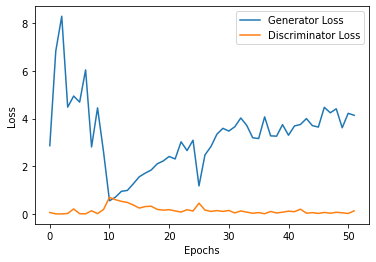

In [20]:
def plot_loss(gen_loss, disc_loss):
    plt.plot(gen_loss, label='Generator Loss')
    plt.plot(disc_loss, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
gen_losses=g_array
discrim_losses=d_array
plot_loss(gen_losses,discrim_losses)

<h3>Image Output

1/1 [==============================] - 0s 227ms/step


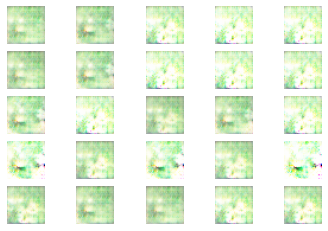

In [21]:
def showplot(examples,n):
    for i in range(n*n):
        plt.subplot(n,n,1+i)
        plt.axis('off')
        plt.imshow(examples[i,:,:,:])
    plt.show()

model=load_model('50base50.h5')
#generate img 100 points 100 imgs
latent_points=generate_latent_points(100,25)
X=model.predict(latent_points)
#scale from -1,1 to 0,1 to get pixel values to 0 to 255
X=(X+1)/2.0
X=(X*255).astype(np.uint8)
showplot(X,5)

<h2>Model improvement is needed